In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
from datetime import datetime

In [2]:
### BLOCK #1 == READ DATA, CALCULATION

In [3]:
df = pd.read_csv('input_data.csv', skiprows = [0, 2])
df = df.sort_values(by=df.columns[0], ignore_index=True)
df

[наименование x]  [наименование y]
0                12               270
1                13               520
2                13               550
3                14               300
4                15               600
5                15               610
6                16               620
7                21               724
8                21               680
9                40               962

In [4]:
x = np.array(df[df.columns[0]].to_list())[:, np.newaxis]
y = np.array(df[df.columns[1]].to_list())[:, np.newaxis]

In [5]:
labels = df.columns.to_list()
del df

In [6]:
# create a linear regression model
model = LinearRegression()
model.fit(x, y)

# predict y from the data
x_new = np.linspace(x.min(), x.max(), 100)
y_new = model.predict(x_new[:, np.newaxis])

In [7]:
r2 = r2_score(y, model.predict(x))
print("coefficient of determination: %.2f" % r2)
print("coef_: %.2f" % model.coef_)
print("intercept_: %.2f" % model.intercept_)
sign = "+" if model.intercept_ > 0 else "-"
FUNCTION = ("%.2f" %model.coef_ + f"x{sign}" + "%.2f" % model.intercept_)
print("approximation function: "+FUNCTION)

coefficient of determination: 0.68
coef_: 19.71
intercept_: 228.89
approximation function: 19.71x+228.89


In [8]:
#model.predict([[21]]) # предсказываем значение по произвольному аргументу

In [9]:
### BLOCK #2 == CREATE PLOT

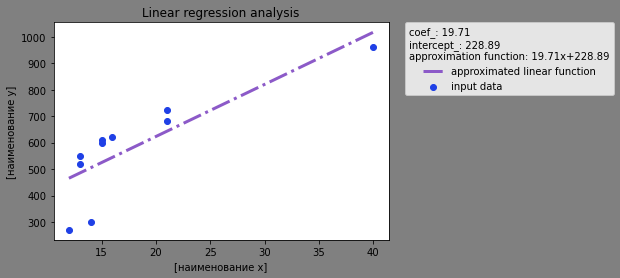

In [10]:
# plot the results
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.scatter(x, y, color="#1F40E6", label='input data')
ax.plot(x_new, y_new, color="#8C5AC8", linewidth=3, linestyle="-.", label="approximated linear function")

# in_work > вывести формулу завиcимости
# in_work > оформление графика для презентации
fig.set(facecolor='grey')
ax.set(title='Linear regression analysis',
      xlabel=labels[0],
       ylabel=labels[1],
      )

legend_title = ("coef_: %.2f" % model.coef_ + "\nintercept_: %.2f" %model.intercept_
                + "\napproximation function: " + FUNCTION
               )
legend = plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.axis('tight')

plt.show()

In [11]:
# Save the figure
if not os.path.exists('figures'):
    os.mkdir('figures')

fig.savefig('figures/figure', dpi=150, bbox_inches='tight')

In [12]:
### BLOCK #3 == CREATE EMAIL CONTENT & SEND MESSAGE

In [13]:
import smtplib

from string import Template

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase 
from email import encoders

In [14]:
MY_ADDRESS, PASSWORD = 'dm283@yandex.ru', 'vch83590*#%()'
HOST, PORT = 'smtp.yandex.ru', 25

def get_contacts(filename):
    names = []
    emails = []
    with open(filename, mode='r', encoding='utf-8') as contacts_file:
        for a_contact in contacts_file:
            names.append(a_contact.split()[0])
            emails.append(a_contact.split()[1])
    return names, emails

def read_template(filename):
    with open(filename, 'r', encoding='utf-8') as template_file:
        template_file_content = template_file.read()
    return Template(template_file_content)

def main():
    names, emails = get_contacts('email_content/mycontacts.txt')
    message_template = read_template('email_content/message_dev.html')

    # set up the SMTP server
    s = smtplib.SMTP(host=HOST, port=PORT)
    s.starttls()
    s.login(MY_ADDRESS, PASSWORD)

    # For each contact, send the email:
    for name, email in zip(names, emails):
        # create a message
        msg = MIMEMultipart()       

        # add in the actual person name to the message template
        message = message_template.substitute(
            COEF=model.coef_,
            INTERCEPT=model.intercept_,
            R2=r2, 
            FUNCTION=FUNCTION,
            DEP_LVL=r2)
        #message = message_template.substitute(DEP_LVL=r)

        # setup the parameters of the message
        msg['From']=MY_ADDRESS
        msg['To']=email
        msg['Subject']=f"Расчет линейной регрессии <{datetime.now()}>"
        
        # add in the message body
        msg.attach(MIMEText(message, 'html'))
        
        
        # add graphics
        with open('figures/figure.png', 'rb') as fp:
            image = MIMEImage(fp.read())
        image.add_header('Content-ID', '<graphic1>')
        msg.attach(image)
        
        # add email static_content pictures
        lst_email_content_static = ['ds_symbol.png',
                                    'python-logo.png',
                                    'numpy_logo.png',
                                    'pandas_logo.png',
                                    'mpl_logo.png',
                                    'scikit-learn-logo.png']
        for c, file in enumerate(lst_email_content_static):
            with open( ('email_content/'+file), 'rb' ) as fp:
                image = MIMEImage(fp.read())
            image.add_header('Content-ID', f'<img{c}>')
            msg.attach(image)
            
        #add attachment###############################
        # open the file to be sent  
        filename = "input_data.csv"
        attachment = open(filename, "rb") 
        p = MIMEBase('application', 'octet-stream') 
        p.set_payload((attachment).read()) 
        encoders.encode_base64(p) 
        p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
        msg.attach(p)
        ##############################################
        
        s.send_message(msg)
        
        del msg
        
    # Terminate the SMTP session and close the connection
    s.quit()
    
if __name__ == '__main__':
    main()